# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from `loading and inspecting the dataset`; -to `implementing`, `training and evaluating a Convolutional Neural Network based architecture`. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- Please select at least ANY 3 objects of choice. Try to pick unique objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is October 25th Friday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:** Ferdinand Kulman  
**Neptun ID:** YR9905  
**Network:** Yolo 11  
**Objects:** Electronic piano, Fender Jazz Bass, KRK studio monitor  

## Task description

**Your task** is to train your own custom object detection model and compare its performance with an existing object detection model (i.e., YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.

- There is no expectation of high performance, but **your metrics should show results better than random guessing, and your loss must decrease throughout the epochs**.

- We expect you to visualize the key metrics such as precision, recall, F1-score, mAP (mean average precision), IoU (Intersection over Union), and localization loss, in addition to monitoring the overall loss and its reduction across training. Use plots and visualizations (e.g., matplotlib, seaborn) to display metrics, losses, and predictions.

- You should implement techniques to avoid overfitting, such as Early Stopping, and save the best-performing model during training.

- Additionally, you can use **WandB (Weights and Biases)** or **TensorBoard** to track and visualize training progress, monitor the model's performance, and log metrics over time.

`Good luck!`

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import (precision_score, recall_score,
                             average_precision_score, roc_auc_score)
from sklearn.preprocessing import label_binarize


# 1. DATASET
**For this assignment you are free to pick any 3 objects of your choice.** Please avoid offensive, inappropriate or violent objects.

### 1.1. Load objects

**Please select 3 or more objects.** After selecting the objects, **remove the background, keeping only the object itself**. You can do this manually, online, or by using code (this step is not part of the assignment evaluation).

As an example, the following objects were chosen (with the background removed using the Segment Anything Model):

In [4]:
!rm -rf figures
!cp -r "/drive/My Drive/DND" "/content/figures"

### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:

- **Inserting an object in a random position** on a background image.

**Therefore, collect a few background images from different locations** This can be done manually or via code.

It is recommended to use **icrawler** to automate the image collection process.


In [5]:
!pip install icrawler

In [6]:
!mkdir background

In case of any errors, try using a different crawler. You can use one of the following options:

```python
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler


In [7]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['halász bástya', 'strand festival', 'keleti railway station budapest', 'celldömölk', 'palm tree tenerife']:
    google_crawler.crawl(
        keyword=keyword, max_num=20, file_idx_offset='auto') #, min_size=(500, 500),)

#Some images may return an error, but icrawler tries to find other images regardless

2024-10-25 10:29:54,027 - INFO - icrawler.crawler - start crawling...
2024-10-25 10:29:54,028 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-25 10:29:54,029 - INFO - feeder - thread feeder-001 exit
2024-10-25 10:29:54,030 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-25 10:29:54,033 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-25 10:29:55,002 - INFO - parser - parsing result page https://www.google.com/search?q=hal%C3%A1sz+b%C3%A1stya&ijn=0&start=0&tbs=&tbm=isch
2024-10-25 10:29:55,191 - INFO - downloader - image #1	http://budapest.kornyeke.hu/fotok/tartalom/9/8917-23032283607284415.jpg
2024-10-25 10:29:55,246 - INFO - downloader - image #2	https://d3iso9mq9tb10q.cloudfront.net/magefan_blog/sightseeing/Budapest-Landmark-Fishermans-Bastion-Big-Bus-Tours.jpg
2024-10-25 10:29:55,247 - INFO - downloader - image #3	https://csodalatosmagyarorszag.hu/wp-content/uploads/2020/03/budapest-halaszbastya-budai-var-fishermens-bastion-csoda

2024-10-25 10:30:14,746 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2024-10-25 10:30:14,746 - INFO - parser - thread parser-001 exit
2024-10-25 10:30:14,839 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2024-10-25 10:30:14,839 - INFO - parser - thread parser-001 exit


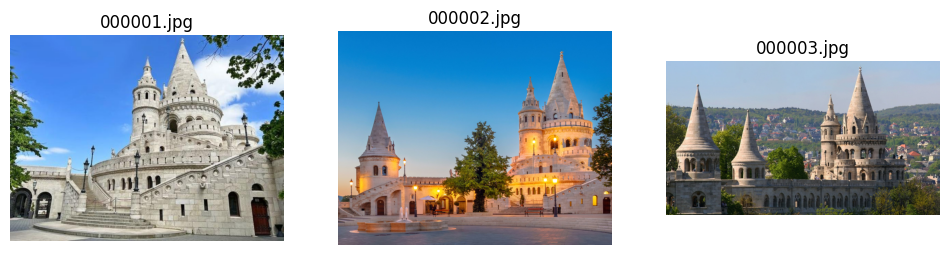

In [8]:
directory = 'background'

def display_sample_images(directory):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    for i, filename in enumerate(os.listdir(directory)[:3]):
        image = Image.open(os.path.join(directory, filename))
        axes[i].imshow(image)
        axes[i].set_title(filename)
        axes[i].axis('off')
    plt.show()
    pass

display_sample_images(directory)

### 1.3. Create dataset

### Dataset Creation

This is a crucial part of the assignment evaluation. From the selected objects and collected background images, follow these steps to generate your dataset:

1. **Randomly select background images** from your collection.
2. **Insert a single object** (from the three selected) into each background image at a **random location**.
3. **Record the object's coordinates** and create a corresponding bounding box. For example:
   - If an object with height `h` and width `w` is placed at position `(x, y)`, the bounding box should be in one of the following formats:
     - **[x, y, w, h]** or
     - **[x1, y1, x2, y2]**, where `x2 = x1 + w` and `y2 = y1 + h`.
4. If you plan to compare your custom model with a YOLO model, use the **YOLO bounding box format**:
   - `[(x + w/2)/image_width, (y + h/2)/image_height, w/image_width, h/image_height]`, where `image` refers to the background image dimensions.
5. **Save the generated dataset**, as it will be used for training your custom model and fine-tuning the existing object detection model.
6. **Wrap the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Split the dataset** into training, validation, and test sets to evaluate your model effectively.


In [9]:
!rm -rf dataset

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
def create_dataset(root_dir, split, img_size, num_images):
    split_dir = os.path.join(root_dir, split)
    images_dir = os.path.join(split_dir, "images")
    labels_dir = os.path.join(split_dir, "labels")

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    bg_images = os.listdir("background")
    obj_images = [f for f in os.listdir("figures") if os.path.isfile(os.path.join("figures", f))]

    obj_map = { name: i for i, name in enumerate(obj_images)}

    for i in range(num_images):
        bg_image_path = os.path.join("background", random.choice(bg_images))
        bg_image = Image.open(bg_image_path).convert("RGBA").resize(img_size)

        obj_size = random.randint(100, 200)
        obj_size = (obj_size, obj_size)
        obj_image_name = random.choice(obj_images)
        obj_image_path = os.path.join("figures", obj_image_name)
        obj_index = obj_map[obj_image_name]
        obj_image = Image.open(obj_image_path).convert("RGBA").resize(obj_size)

        px = random.randint(0, img_size[0] - obj_size[0])
        py = random.randint(0, img_size[1] - obj_size[1])
        bx = (px + obj_size[0] / 2) / img_size[0]
        by = (py + obj_size[1] / 2) / img_size[1]
        bw = obj_size[0] / img_size[0]
        bh = obj_size[1] / img_size[1]

        bg_image.paste(obj_image, (px, py), obj_image)

        out_image_path = os.path.join(images_dir, f"{i:05d}.png")
        bg_image.save(out_image_path)

        label_path = os.path.join(labels_dir, f"{i:05d}.txt")
        with open(label_path, "w") as label:
            label.write(f"{obj_index} {bx} {by} {bw} {bh}")

create_dataset("dataset", "train", (512, 512), 1500)
create_dataset("dataset", "val", (512, 512), 500)
create_dataset("dataset", "test", (512, 512), 100)

In [3]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.txt'))

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        bbox_list = []
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                class_id = int(parts[0])
                bbox = [float(coord) for coord in parts[1:]]
                bbox_list.append((class_id, bbox))

        labels = [item[0] for item in bbox_list]
        bboxes = [item[1] for item in bbox_list]

        return image, torch.tensor(labels, dtype=torch.long), torch.tensor(bboxes, dtype=torch.float32)



In [4]:
root_dir = 'dataset'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ObjectDetectionDataset(
    root_dir=root_dir,
    split='train',
    transform=transform
)

val_dataset = ObjectDetectionDataset(
    root_dir=root_dir,
    split='val',
    transform=transform
)

test_dataset = ObjectDetectionDataset(
    root_dir=root_dir,
    split='test',
    transform=transform
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


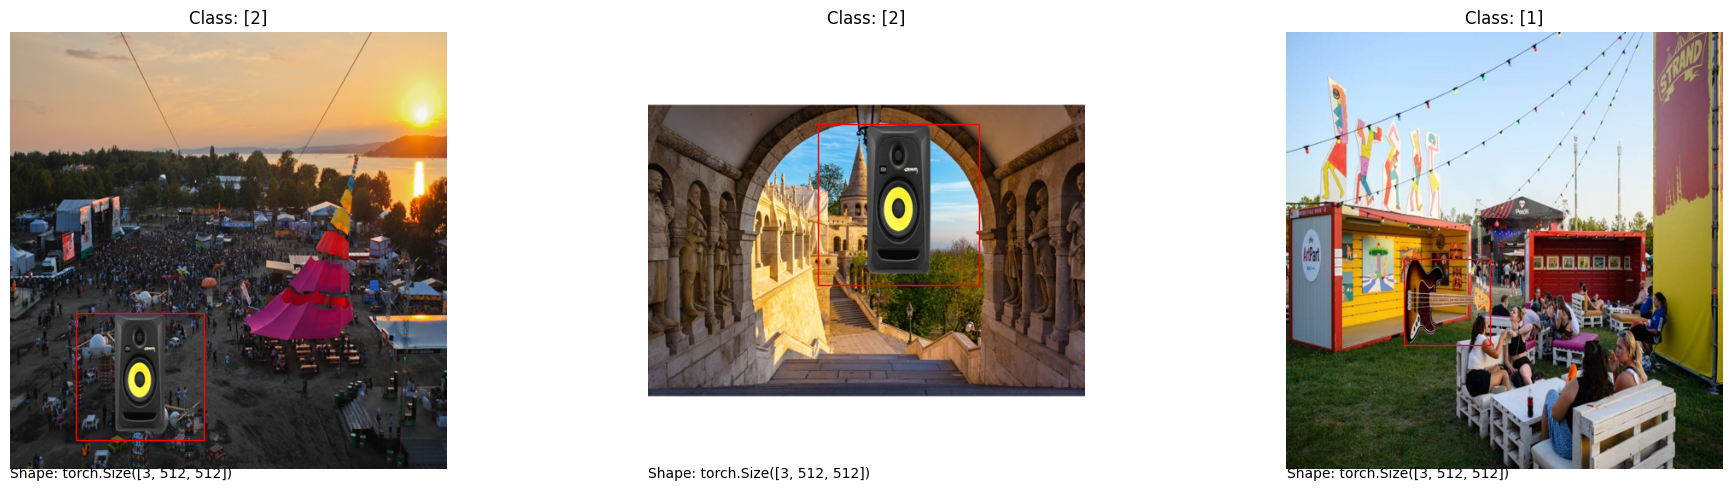

In [5]:
def visualize_dataset(dataset, sample_size=3):
    fig, axes = plt.subplots(1, sample_size, figsize=(20, 5))
    random_indices = random.sample(range(len(dataset)), sample_size)

    for i, idx in enumerate(random_indices):
        image, labels, bbox_list = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))


        for bbox_item in bbox_list:
            bbox_x, bbox_y, bbox_w, bbox_h = bbox_item.tolist()

            bbox_x *= image.shape[2]
            bbox_y *= image.shape[1]
            bbox_w *= image.shape[2]
            bbox_h *= image.shape[1]

            rect = patches.Rectangle(
                (bbox_x - bbox_w / 2, bbox_y - bbox_h / 2),
                bbox_w, bbox_h,
                linewidth=1, edgecolor='r', facecolor='none'
            )
            axes[i].add_patch(rect)

        axes[i].set_title(f'Class: {labels.tolist()}')
        axes[i].axis('off')


        axes[i].text(0, image.shape[1] + 10, f'Shape: {image.shape}', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

visualize_dataset(train_dataset)


### 2. MODELS

In this assignment, you are tasked with building your own custom object detection model and comparing its performance against an existing object detection model.


### 2.1. Custom Object Detection model

### Create a Convolutional Neural Network (CNN) Architecture

Design a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes, e.g., 3).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in your chosen format).

This is the core evaluation of the assignment. Experiment with different layers, hyperparameters, and regularization techniques to optimize the model's performance.


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()

        self.layer1 = self._create_conv_layer(3, 16)
        self.layer2 = self._create_conv_layer(16, 32)
        self.layer3 = self._create_conv_layer(32, 64)

        self.flatten_size = self._get_flatten_size((3, 512, 512))

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc_class = nn.Linear(128, num_classes)
        self.fc_bbox = nn.Linear(128, 4)

    def _create_conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def _get_flatten_size(self, input_shape):
        x = torch.rand(1, *input_shape)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x.numel()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(out.size(0), -1)

        out = nn.ReLU()(self.fc1(out))

        class_out = self.fc_class(out)
        bbox_out = self.fc_bbox(out)

        return class_out, bbox_out

    def load_model(model_path, num_classes):
        model = CustomModel(num_classes=num_classes)

        model.load_state_dict(torch.load(model_path))

        model.eval()

        return model

In [8]:
dummy_image = torch.randn(1, 3, 512, 512).to(device)
num_classes = 3
dummy_image.shape

model = CustomModel(num_classes).to(device)

class_probs, bbox_regression = model(dummy_image)

print("Class Output Shape:", class_probs.shape)
print("Bounding Box Output Shape:", bbox_regression.shape)

Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train Your Model

Carefully choose key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques**. Ensure you're optimizing both **classification loss** and **bounding box regression loss**.

Monitor for signs of **overfitting** or **underfitting** by tracking how the loss evolves across epochs. The loss should consistently decrease as training progresses. Save and log these losses for visualization and further analysis.


**Example Plot**:

<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

Epoch [1/100] -> Train Loss: 11.0136, Class Loss: 0.0096, Reg Loss: 11.0040, Val Loss: 5.2778
Epoch [2/100] -> Train Loss: 5.1620, Class Loss: 0.0000, Reg Loss: 5.1620, Val Loss: 6.0720
Epoch [3/100] -> Train Loss: 2.4799, Class Loss: 0.0000, Reg Loss: 2.4799, Val Loss: 0.1486
Epoch [4/100] -> Train Loss: 0.3012, Class Loss: 0.0079, Reg Loss: 0.2934, Val Loss: 0.0211
Epoch [5/100] -> Train Loss: 0.0328, Class Loss: 0.0048, Reg Loss: 0.0279, Val Loss: 0.0165
Epoch [6/100] -> Train Loss: 0.0188, Class Loss: 0.0011, Reg Loss: 0.0177, Val Loss: 0.0141
Epoch [7/100] -> Train Loss: 0.0137, Class Loss: 0.0003, Reg Loss: 0.0134, Val Loss: 0.0163
Epoch [8/100] -> Train Loss: 0.0123, Class Loss: 0.0002, Reg Loss: 0.0121, Val Loss: 0.0103
Epoch [9/100] -> Train Loss: 0.0098, Class Loss: 0.0001, Reg Loss: 0.0097, Val Loss: 0.0090
Epoch [10/100] -> Train Loss: 0.0075, Class Loss: 0.0000, Reg Loss: 0.0074, Val Loss: 0.0059
Epoch [11/100] -> Train Loss: 0.0056, Class Loss: 0.0000, Reg Loss: 0.0055, V

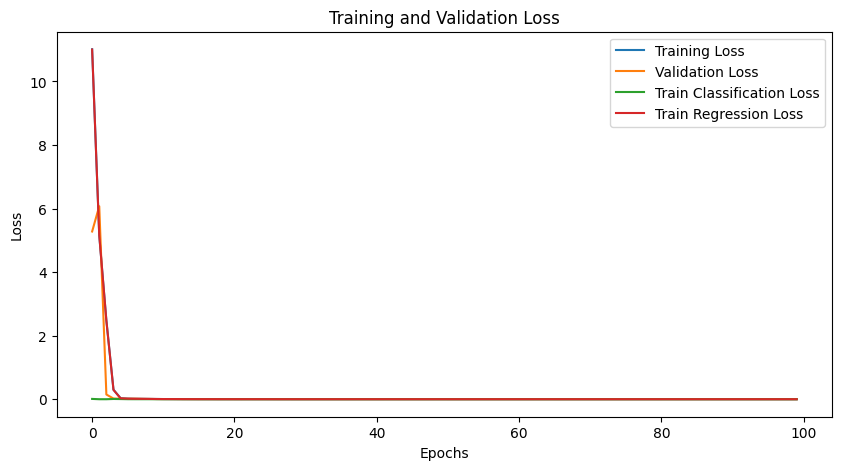

In [9]:
train_classification_losses = []
train_regression_losses = []

def plot_training_curves(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.plot(train_classification_losses, label="Train Classification Loss")
    plt.plot(train_regression_losses, label="Train Regression Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

def train_model(model, train_loader, val_loader, optimizer=None, class_loss_fn=None, bbox_loss_fn=None, num_epochs=10):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optimizer or optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

    class_loss_fn = class_loss_fn or nn.CrossEntropyLoss()
    bbox_loss_fn = bbox_loss_fn or nn.SmoothL1Loss()

    training_losses, validation_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, class_loss_sum, reg_loss_sum = 0, 0, 0

        for images, labels, bboxes in train_loader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)

            optimizer.zero_grad()
            predicted_classes, predicted_bboxes = model(images)

            labels = torch.argmax(labels, dim=1) if labels.dim() > 1 else labels
            bboxes = bboxes.view_as(predicted_bboxes)

            classification_loss = class_loss_fn(predicted_classes, labels)
            regression_loss = bbox_loss_fn(predicted_bboxes, bboxes)
            total_loss = classification_loss + regression_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            batch_size = images.size(0)
            total_train_loss += total_loss.item() * batch_size
            class_loss_sum += classification_loss.item() * batch_size
            reg_loss_sum += regression_loss.item() * batch_size

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_class_loss = class_loss_sum / len(train_loader.dataset)
        avg_reg_loss = reg_loss_sum / len(train_loader.dataset)

        training_losses.append(avg_train_loss)
        train_classification_losses.append(avg_class_loss)
        train_regression_losses.append(avg_reg_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for val_images, val_labels, val_bboxes in val_loader:
                val_images, val_labels, val_bboxes = val_images.to(device), val_labels.to(device), val_bboxes.to(device)

                val_class_preds, val_bbox_preds = model(val_images)
                val_labels = torch.argmax(val_labels, dim=1) if val_labels.dim() > 1 else val_labels
                val_bboxes = val_bboxes.view_as(val_bbox_preds)

                val_class_loss = class_loss_fn(val_class_preds, val_labels)
                val_reg_loss = bbox_loss_fn(val_bbox_preds, val_bboxes)
                total_val_loss += (val_class_loss + val_reg_loss).item() * val_images.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        validation_losses.append(avg_val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, '
              f'Class Loss: {avg_class_loss:.4f}, Reg Loss: {avg_reg_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}')

        scheduler.step(avg_val_loss)

    plot_training_curves(training_losses, validation_losses)

    return model, training_losses, validation_losses

myModel = CustomModel(num_classes=3)  # Assuming CustomModel is defined elsewhere
trained_model, train_losses, val_losses = train_model(myModel, train_loader, val_loader, num_epochs=100)

In [ ]:
#local model save
torch.save(myModel.state_dict(), 'model.pt')

In [ ]:
#drive save
model_save_name = 'mode-ldrive.pt'
path = "/drive/My Drive/DND/"
torch.save(myModel.state_dict(), path)

### 2.3. Evaulate and do inference with the trained custom model

Choose **at least 3 metrics** to evaluate your object detection model. These could include:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **F1-Score**: The harmonic mean of Precision and Recall, balancing false positives and false negatives.
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.
  
Additionally, you can assess:
- **Inference speed**: Time taken by the model to process a single image.
- **Number of parameters**: The total number of trainable parameters in the model.
- **Model size**: The disk size of the trained model.

### Show Performance Metric Visualizations

- Visualize the chosen metrics (e.g., **Precision, Recall, F1-Score, IoU, mAP**) over different epochs to demonstrate the improvement in the model’s performance.
- Plot losses (both classification loss and localization loss) to show how they decrease throughout training.

### Show Some Predictions of Your Trained Model

- Display sample images with **predicted bounding boxes** and compare them to the ground truth.
- Highlight the values of **Precision, Recall, IoU**, or other relevant metrics for each displayed prediction, giving a clear view of the model's performance.
  
You can also use **WandB (Weights and Biases)** or **TensorBoard** for more detailed logging and tracking of these metrics and visualizations.


In [10]:
def evaluate_test_set(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    all_bbox_preds = []
    all_bbox_targets = []
    with torch.no_grad():
        for image, labels, bbox_list in test_loader:
            image = image.to(device)
            labels = labels.to(device)
            bbox_list = bbox_list.to(device)
            class_probs, bbox_regression = model(image)
            _, predicted = torch.max(class_probs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_bbox_preds.extend(bbox_regression.cpu().numpy())
            all_bbox_targets.extend(bbox_list.cpu().numpy())
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_targets, all_predictions, average='macro')
    all_targets_binary = label_binarize(all_targets, classes=np.unique(all_targets))
    all_predictions_binary = label_binarize(all_predictions, classes=np.unique(all_predictions))
    mAP = roc_auc_score(all_targets_binary, all_predictions_binary, average='macro', multi_class='ovr')
    return precision, recall, mAP

precision, recall, mAP = evaluate_test_set(myModel, test_loader, device)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')

Precision: 0.7800, Recall: 0.3333, mAP: 0.5000


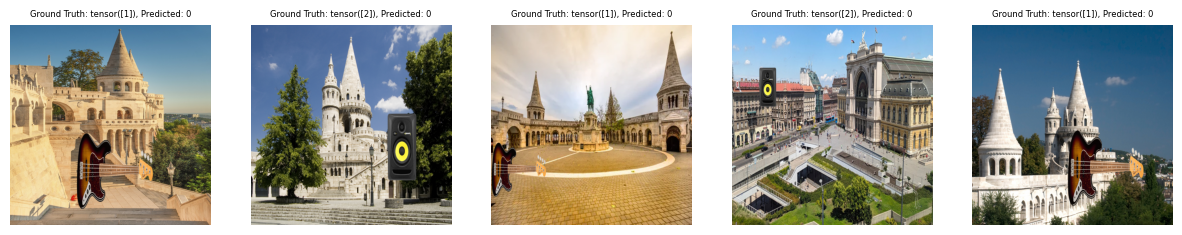

In [11]:
def visualize_predictions(model, test_dataset,num_samples=5):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples, shuffle=True)

    images, labels, _ = next(iter(test_loader))

    device = next(model.parameters()).device
    images = images.to(device)

    with torch.no_grad():
        class_probs,_ = model(images)

    _, predicted_labels = torch.max(class_probs, 1)

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))  # Convert image to numpy format
        plt.title(f'Ground Truth: {labels[i]}, Predicted: {predicted_labels[i]}',fontsize=6)
        plt.axis('off')
        plt.tick_params(axis='both', which='both', labelsize=4)
    plt.show()

visualize_predictions(myModel, test_dataset)

### 2.4. Load an Existing Object Detection Model

We recommend using the latest **YOLO** version, but you are free to choose any other **PyTorch-based** object detection model.


In [16]:
!pip install ultralytics

   ---------------------------------------- 0.0/877.5 kB ? eta -:--:--
   ---------------------------------------- 877.5/877.5 kB 9.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   -- ------------------------------------- 2.4/38.8 MB 12.3 MB/s eta 0:00:03
   ----- ---------------------------------- 5.0/38.8 MB 12.1 MB/s eta 0:00:03
   ------- -------------------------------- 7.6/38.8 MB 12.4 MB/s eta 0:00:03
   ---------- ----------------------------- 10.0/38.8 MB 12.4 MB/s eta 0:00:03
   ------------ --------------------------- 12.6/38.8 MB 12.3 MB/s eta 0:00:03
   --------------- ------------------------ 14.9/38.8 MB 12.4 MB/s eta 0:00:02
   ------------------ --------------------- 17.6/38.8 MB 12.4 MB/s eta 0:00:02
   -------------------- ------------------- 20.2/38.8 MB 12.4 MB/s eta 0:00:02
   ----------------------- ---------------- 22.5/38.8 MB 12.4 MB/s eta 0:00:02
   ------------------------- -------------- 25.2/38.8 MB 12.5 MB/s eta 

In [2]:
from zipfile import ZipFile
import os
from ultralytics import YOLO
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.ops import box_iou
from collections import defaultdict

#### 2.4.1 Open the yaml

In [1]:
with open('yolo.yaml', 'w') as f:
    f.write("path: dataset/\n")
    f.write("train: train/images/\n")
    f.write("val: val/images/\n")
    f.write("test: test/images/\n")
    f.write("names:\n")
    f.write("  0: epiano\n")
    f.write("  1: jazzbass\n")
    f.write("  2: krk\n")

### 2.5. Fine-tune the existing object detection model
If you choose to use **YOLO**, training the model can be done easily by providing a `data.yaml` file (which follows a specific format, check the official GitHub repository for details) and running the training script.

For example, you can run YOLO from the command line with:

```bash
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640
```

Make sure to show the losses and metrics visualizations. By default, YOLO should **verbose** those.

In [3]:
yolo_test = YOLO("yolo11n.yaml")
results = yolo_test.train(data="yolo.yaml", epochs=10, imgsz=512, batch=16, project="yolo-comp", name="Test")

Ultralytics 8.3.22  Python-3.12.6 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.yaml, data=yolo.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo-comp, name=Test, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning E:\Egyetem-msc\1\deep network\fos\datasets\dataset\train\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
val: Scanning E:\Egyetem-msc\1\deep network\fos\datasets\dataset\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to yolo-comp\Test\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to yolo-comp\Test
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.82G      2.432      5.024       4.25          4        512: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        100        100   0.000336      0.117   0.000206   4.79e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.94G      2.282       4.75      3.839          4        512: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        100   0.000349      0.141   0.000253   4.12e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.94G      2.089      4.198       3.25          4        512: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        100        100   0.000406     0.0598   0.000673   0.000119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.94G      1.873      3.509      2.831          4        512: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        100    0.00364      0.969      0.113     0.0514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.94G      1.745      2.909      2.643          4        512: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        100      0.722      0.614      0.717      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.94G      1.726      2.704      2.624          4        512: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        100        100      0.542      0.748      0.753      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.94G      1.559       2.38      2.454          4        512: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        100        100      0.769      0.764      0.813      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.94G       1.48      2.175      2.385          4        512: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        100        100      0.793      0.942      0.915      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.94G       1.38      2.003      2.273          4        512: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        100      0.787      0.943      0.943      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.94G      1.323      1.878      2.212          4        512: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        100        100      0.824      0.952      0.941      0.706



10 epochs completed in 0.052 hours.
Optimizer stripped from yolo-comp\Test\weights\last.pt, 5.4MB
Optimizer stripped from yolo-comp\Test\weights\best.pt, 5.4MB

Validating yolo-comp\Test\weights\best.pt...
WARNING  validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.22  Python-3.12.6 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


                   all        100        100      0.825      0.952      0.941      0.706
                epiano         36         36       0.78      0.944      0.914      0.671
              jazzbass         34         34      0.798      0.912      0.916       0.61
                   krk         30         30      0.896          1      0.994      0.839
Speed: 0.2ms preprocess, 6.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to yolo-comp\Test


### 2.6 Evaluate the existing object detection model
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** using the **same metrics** chosen in **Step 2.3** (e.g., Precision, Recall, F1-Score, IoU, mAP).


In [12]:
def evaluate_yolo_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels, bboxes in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Make predictions
            predictions = model(images)  # Outputs will contain predictions

            # Extract predicted classes and bounding boxes
            for pred in predictions:
                predicted_classes = pred['boxes'][:, -1].cpu().numpy()  # Get predicted class indices
                all_predictions.extend(predicted_classes)

            all_targets.extend(labels.cpu().numpy())

    # Assuming labels are in integer format
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_targets, all_predictions, average='macro')

    # Binarize the results for mAP calculation
    all_targets_binary = label_binarize(all_targets, classes=np.unique(all_targets))
    all_predictions_binary = label_binarize(all_predictions, classes=np.unique(all_predictions))

    # Calculate mean Average Precision (mAP)
    mAP = roc_auc_score(all_targets_binary, all_predictions_binary, average='macro', multi_class='ovr')

    return precision, recall, mAP

# Load your YOLO model
model_path = './yolo11n.pt'  # Adjust this path
yolo_model = load_yolo_model(model_path).to(device)

# Evaluate the YOLO model
precision, recall, mAP = evaluate_yolo_model(yolo_test, test_loader, device)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ferdi\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ferdi\AppData\Local\Temp\ipykernel_14676\561748159.py", line 40, in <module>
    yolo_model = load_yolo_model(model_path).to(device)
                                                ^^^^^^
NameError: name 'device' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ferdi\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 2168, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ferdi\AppData\Roaming\Python\Python312\site-packages\IPython\core\ultratb.py", line 1457, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^

# 3. COMPARISON
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** for a fair comparison. Key metrics to include:

- **Precision**
- **Recall**
- **F1-Score**
- **IoU (Intersection over Union)**
- **mAP (mean Average Precision)**

### Visualize Predictions

- Show predictions from both models on the same images.
- Include bounding boxes, class labels, and relevant metrics like IoU or Precision.

### Explain Differences

- Discuss why one model may perform better than the other, considering architecture, dataset complexity, or fine-tuning.

### Improve Custom Model

- Suggest improvements such as better data augmentation, model architecture adjustments, hyperparameter tuning, or more training data.
- Explore **Transfer Learning**, **learning rate scheduling**, or new optimizers for better performance.


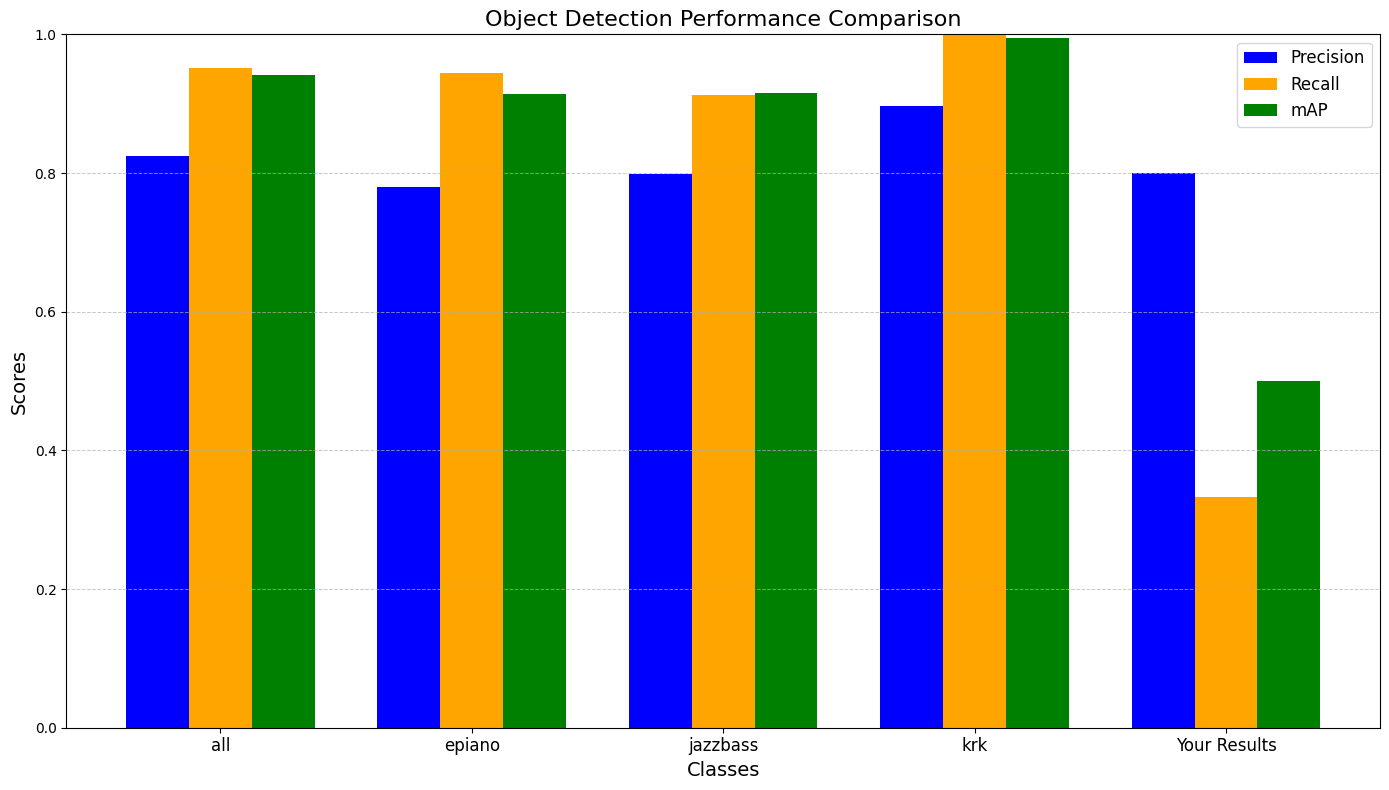

In [12]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['all', 'epiano', 'jazzbass', 'krk']
precision_yolo = [0.825, 0.78, 0.798, 0.896]
recall_yolo = [0.952, 0.944, 0.912, 1.0]
map_yolo = [0.941, 0.914, 0.916, 0.994]

your_precision = 0.8000
your_recall = 0.3333
your_map = 0.5000

precision_comparison = precision_yolo + [your_precision]
recall_comparison = recall_yolo + [your_recall]
map_comparison = map_yolo + [your_map]

comparison_labels = classes + ['Your Results']

bar_width = 0.25
x = np.arange(len(comparison_labels))

plt.figure(figsize=(14, 8))
plt.bar(x - bar_width, precision_comparison, width=bar_width, label='Precision', color='blue')
plt.bar(x, recall_comparison, width=bar_width, label='Recall', color='orange')
plt.bar(x + bar_width, map_comparison, width=bar_width, label='mAP', color='green')

plt.xlabel('Classes', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Object Detection Performance Comparison', fontsize=16)
plt.xticks(x, comparison_labels, fontsize=12)
plt.ylim(0, 1)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()

plt.show()

